In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("CarDataset").getOrCreate()

# Correct file path
file_path = r"C:\Users\S566399\final_scout_not_dummy.csv"  # Raw string

# Read CSV file into DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display DataFrame schema and a sample of the data
df.printSchema()
df.show(5)

root
 |-- make_model: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- vat: string (nullable = true)
 |-- km: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Fuel: string (nullable = true)
 |-- Gears: double (nullable = true)
 |-- Comfort_Convenience: string (nullable = true)
 |-- Entertainment_Media: string (nullable = true)
 |-- Extras: string (nullable = true)
 |-- Safety_Security: string (nullable = true)
 |-- age: double (nullable = true)
 |-- Previous_Owners: double (nullable = true)
 |-- hp_kW: double (nullable = true)
 |-- Inspection_new: integer (nullable = true)
 |-- Paint_Type: string (nullable = true)
 |-- Upholstery_type: string (nullable = true)
 |-- Gearing_Type: string (nullable = true)
 |-- Displacement_cc: double (nullable = true)
 |-- Weight_kg: double (nullable = true)
 |-- Drive_chain: string (nullable = true)
 |-- cons_comb: double (nullable = true)

+----------+---------+-----+---------

In [2]:
# Convert Spark DataFrame to Pandas
df_pd = df.toPandas()


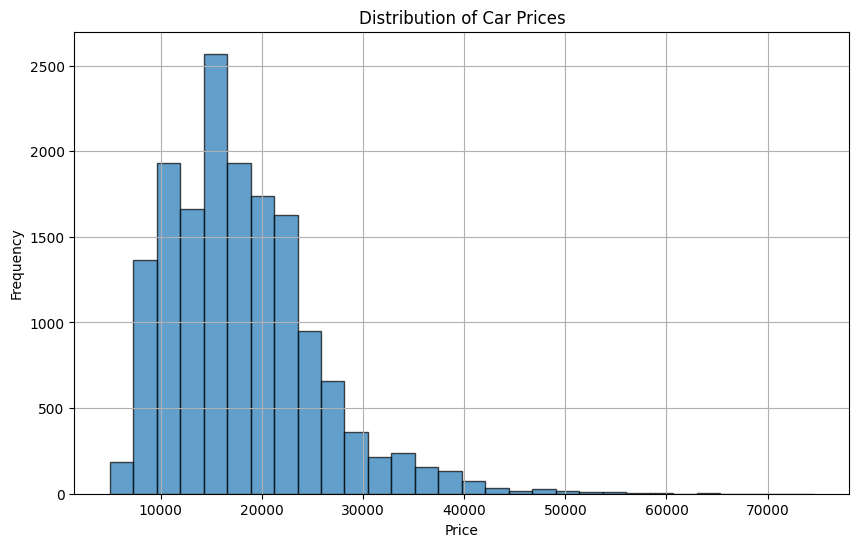

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_pd['price'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

# Select relevant features and target column
features = ["km", "age", "hp_kW", "Displacement_cc", "Weight_kg"]
target = "price"

# Assemble feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
prepared_data = assembler.transform(df.select(*(features + [target])).na.drop())

# Split the data into training and testing sets
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the regression model
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_data)

# Evaluate the model
predictions = lr_model.transform(test_data)
predictions.select("features", "price", "prediction").show()

# Print model coefficients
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|[0.0,0.0,85.0,999...|22720|20775.287710876582|
|[0.0,0.0,85.0,999...|22675|21221.022178919735|
|[0.0,0.0,85.0,159...|27470|20644.355741997875|
|[1.0,0.0,70.0,999...|21390|18056.207363877827|
|[1.0,0.0,70.0,999...|20900|18204.785519892215|
|[1.0,0.0,70.0,999...|21000|18204.785519892215|
|[1.0,0.0,70.0,999...|25900|18204.785519892215|
|[1.0,0.0,85.0,999...|19550|20686.099376769987|
|[1.0,0.0,85.0,999...|23400| 21072.40258240739|
|[1.0,0.0,85.0,999...|24900| 21072.40258240739|
|[1.0,0.0,85.0,999...|24900| 21072.40258240739|
|[1.0,0.0,85.0,999...|25400| 21072.40258240739|
|[1.0,0.0,85.0,999...|26200| 21072.40258240739|
|[1.0,0.0,85.0,999...|24890|21220.980738421775|
|[1.0,0.0,85.0,999...|24800|21339.843263233284|
|[1.0,0.0,85.0,999...|22311|21845.008993682193|
|[1.0,0.0,85.0,999...|22900|21845.008993682193|
|[1.0,0.0,85.0,100...|23500|21338.582895

In [5]:
predictions_pd = predictions.select("price", "prediction").toPandas()


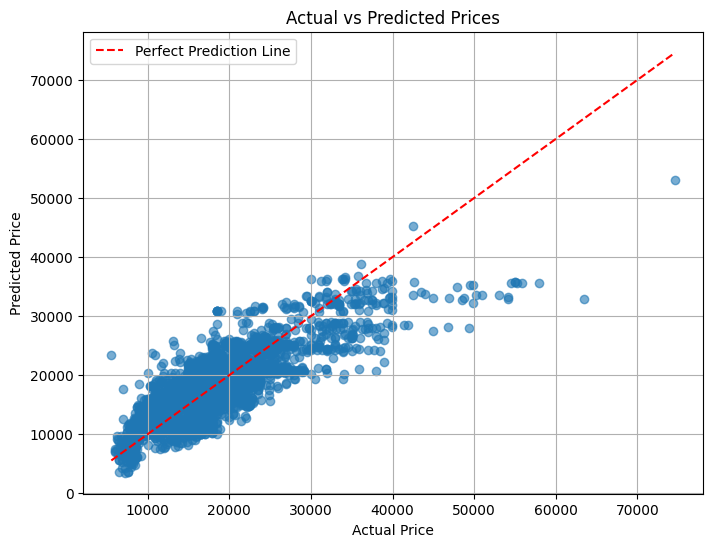

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd['price'], predictions_pd['prediction'], alpha=0.6)
plt.plot([predictions_pd['price'].min(), predictions_pd['price'].max()],
         [predictions_pd['price'].min(), predictions_pd['price'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.show()


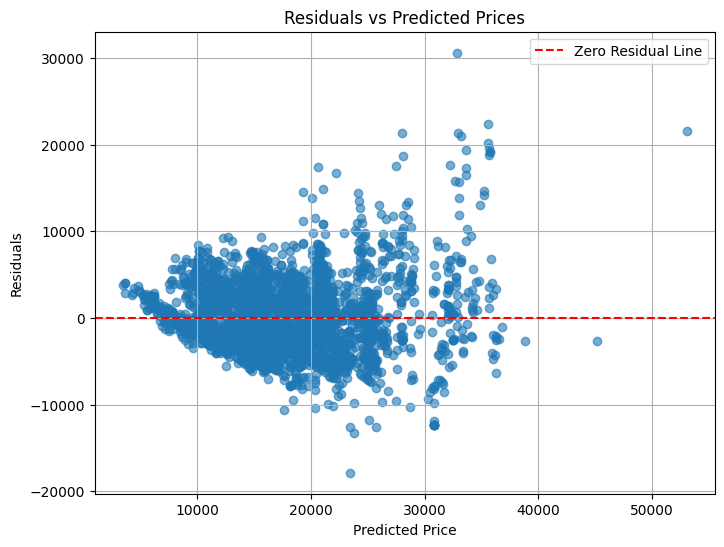

In [7]:
predictions_pd['residual'] = predictions_pd['price'] - predictions_pd['prediction']

plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd['prediction'], predictions_pd['residual'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals vs Predicted Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()


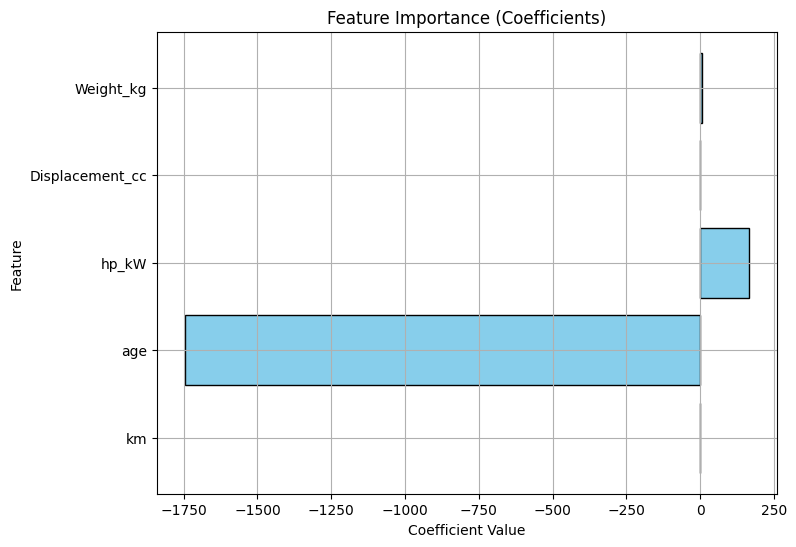

In [8]:
import pandas as pd

# Create a DataFrame for coefficients
features = ["km", "age", "hp_kW", "Displacement_cc", "Weight_kg"]
coefficients = lr_model.coefficients.toArray()
coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Bar Plot
plt.figure(figsize=(8, 6))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='skyblue', edgecolor='k')
plt.title('Feature Importance (Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True)
plt.show()


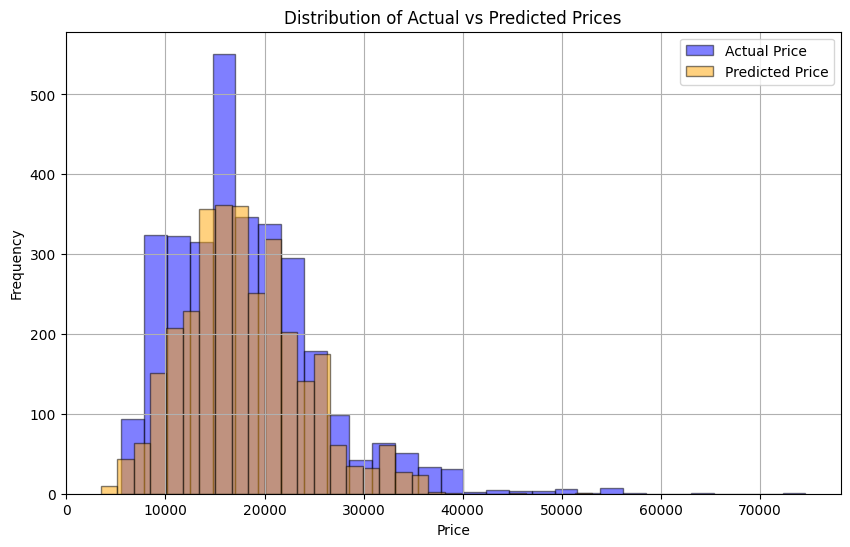

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(predictions_pd['price'], bins=30, alpha=0.5, label='Actual Price', color='blue', edgecolor='k')
plt.hist(predictions_pd['prediction'], bins=30, alpha=0.5, label='Predicted Price', color='orange', edgecolor='k')
plt.title('Distribution of Actual vs Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
#Feature Analysis: Influence of fuel type, hp_kW, displacement, and gearing type on car prices
from pyspark.sql.functions import avg

# Analyze average price, horsepower, and displacement grouped by Fuel and Gearing_Type
df.groupBy("Fuel", "Gearing_Type") \
  .agg(avg("price").alias("avg_price"), 
       avg("hp_kW").alias("avg_hp_kW"), 
       avg("Displacement_cc").alias("avg_displacement")) \
  .orderBy("avg_price", ascending=False) \
  .show()

+--------+--------------+------------------+------------------+------------------+
|    Fuel|  Gearing_Type|         avg_price|         avg_hp_kW|  avg_displacement|
+--------+--------------+------------------+------------------+------------------+
|Electric|Semi-automatic|          34324.75|             120.0|           1396.25|
| Benzine|Semi-automatic| 25388.28481012658|120.82278481012658| 1455.639240506329|
| LPG/CNG|Semi-automatic| 23064.63157894737| 84.15789473684211|1416.6842105263158|
|  Diesel|Semi-automatic|21913.444444444445| 92.95486111111111|1663.2743055555557|
|  Diesel|     Automatic| 21197.00358530027|100.63280549746041|1663.3385121003885|
| Benzine|     Automatic|21141.351894228323| 97.90109331299263|1339.0554284261377|
| LPG/CNG|     Automatic|        20243.6875|             84.75|           1459.75|
|  Diesel|        Manual|15124.564291564291| 83.49522249522249|1582.5629265629266|
| Benzine|        Manual| 14773.65716849899| 73.93874803679606|1190.3493381198116|
| LP

In [11]:
from pyspark.sql.functions import avg

# Perform aggregation
aggregated_data = df.groupBy("Fuel", "Gearing_Type") \
    .agg(avg("price").alias("avg_price"),
         avg("hp_kW").alias("avg_hp_kW"),
         avg("Displacement_cc").alias("avg_displacement")) \
    .orderBy("avg_price", ascending=False)

# Convert to Pandas DataFrame
aggregated_data_pd = aggregated_data.toPandas()


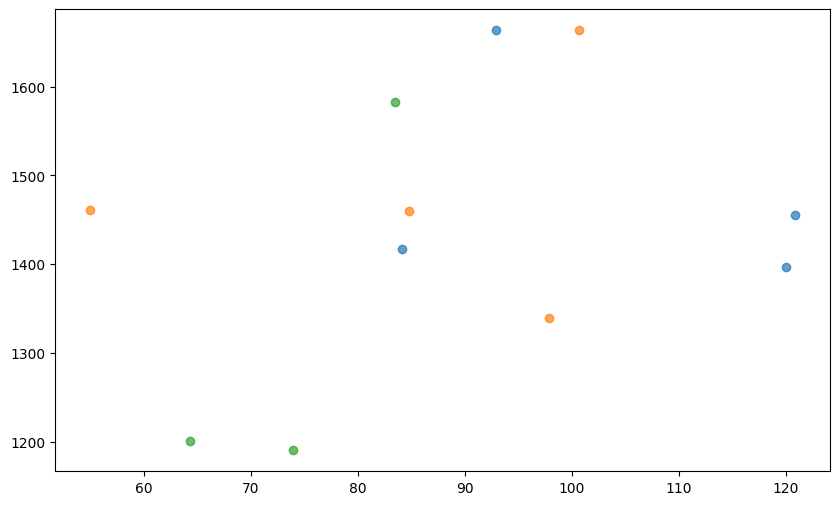

In [12]:
plt.figure(figsize=(10, 6))
for gearing in aggregated_data_pd["Gearing_Type"].unique():
    subset = aggregated_data_pd[aggregated_data_pd["Gearing_Type"] == gearing]
    plt.scatter(
        subset["avg_hp_kW"],
        subset["avg_displacement"],
        label=f"Gearing: {gearing}",
        alpha=0.7
    )


In [13]:
#Customer Segmentation: Cluster vehicles based on features
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Select clustering features
clustering_features = ["price", "hp_kW", "km", "age", "Displacement_cc"]

# Assemble feature vector
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features")
clustering_data = assembler.transform(df.select(*clustering_features).na.drop())

# Apply KMeans clustering
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(clustering_data)
clustered = model.transform(clustering_data)

# Show the clusters
clustered.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[15770.0,66.0,560...|         1|
|[14500.0,141.0,80...|         1|
|[14640.0,85.0,834...|         1|
|[14500.0,66.0,730...|         1|
|[16790.0,66.0,162...|         0|
|[15090.0,85.0,636...|         1|
|[16422.0,85.0,621...|         1|
|[14480.0,66.0,149...|         0|
|[16700.0,85.0,570...|         1|
|[17990.0,70.0,161...|         0|
|[18500.0,85.0,113...|         0|
|[17990.0,92.0,264...|         0|
|[18380.0,92.0,316...|         0|
|[18399.0,112.0,45...|         1|
|[17990.0,70.0,349...|         1|
|[18700.0,85.0,270...|         0|
|[18900.0,85.0,975...|         0|
|[18500.0,66.0,284...|         0|
|[18400.0,70.0,502...|         1|
|[18500.0,85.0,134...|         0|
+--------------------+----------+
only showing top 20 rows



In [14]:
from pyspark.ml.feature import PCA

# Apply PCA to reduce features to 3 dimensions
pca_3d = PCA(k=3, inputCol="features", outputCol="pca_features_3d")
pca_3d_model = pca_3d.fit(clustered)
pca_3d_result = pca_3d_model.transform(clustered)


In [15]:
pca_3d_result.printSchema()


root
 |-- price: integer (nullable = true)
 |-- hp_kW: double (nullable = true)
 |-- km: double (nullable = true)
 |-- age: double (nullable = true)
 |-- Displacement_cc: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)
 |-- pca_features_3d: vector (nullable = true)



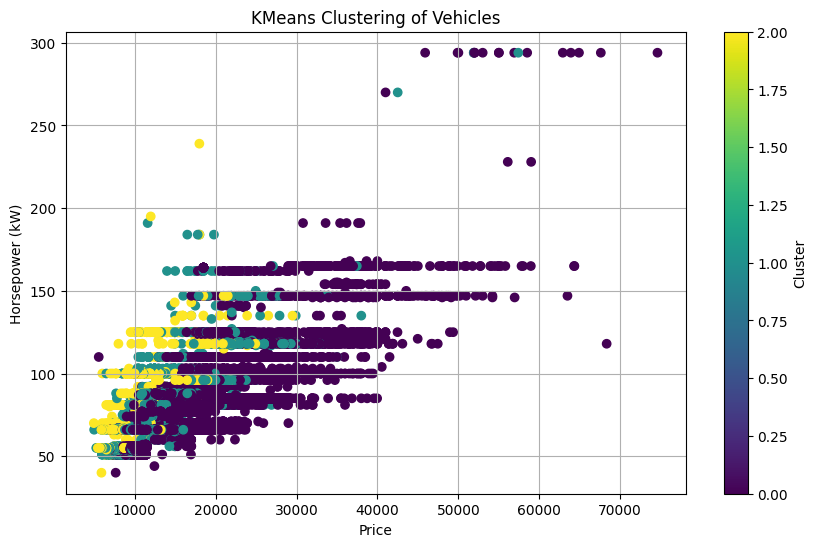

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert clustered PySpark DataFrame to Pandas
clustered_pd = clustered.select("features", "prediction").toPandas()

# Extract features into separate columns
clustered_pd[["price", "hp_kW", "km", "age", "Displacement_cc"]] = pd.DataFrame(
    clustered_pd["features"].tolist(), index=clustered_pd.index
)

# Scatter plot for the first two features ('price' and 'hp_kW')
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    clustered_pd["price"], clustered_pd["hp_kW"], c=clustered_pd["prediction"], cmap="viridis"
)
plt.colorbar(scatter, label="Cluster")
plt.title("KMeans Clustering of Vehicles")
plt.xlabel("Price")
plt.ylabel("Horsepower (kW)")
plt.grid()
plt.show()


In [17]:
#Trend Analysis: Market trends in drivetrain, body types, and features
#a. Drivetrain Preferences
df.groupBy("Drive_chain").count().orderBy("count", ascending=False).show()


+-----------+-----+
|Drive_chain|count|
+-----------+-----+
|      front|15707|
|        4WD|  204|
|       rear|    4|
+-----------+-----+



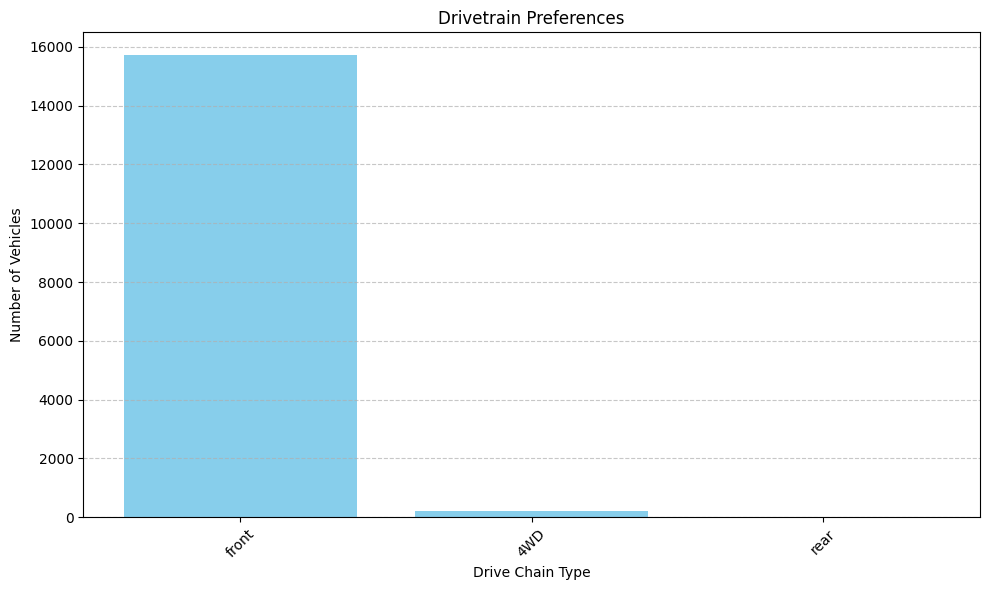

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate drivetrain preferences
drivetrain_counts = (
    df.groupBy("Drive_chain")
    .count()
    .orderBy("count", ascending=False)
    .toPandas()
)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(drivetrain_counts["Drive_chain"], drivetrain_counts["count"], color='skyblue')
plt.title("Drivetrain Preferences")
plt.xlabel("Drive Chain Type")
plt.ylabel("Number of Vehicles")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
# Body Type Preferences
df.groupBy("body_type").count().orderBy("count", ascending=False).show()


+-------------+-----+
|    body_type|count|
+-------------+-----+
|       Sedans| 8004|
|Station wagon| 3677|
|      Compact| 3240|
|          Van|  817|
|  Transporter|   88|
|     Off-Road|   56|
|        Coupe|   25|
|  Convertible|    8|
+-------------+-----+



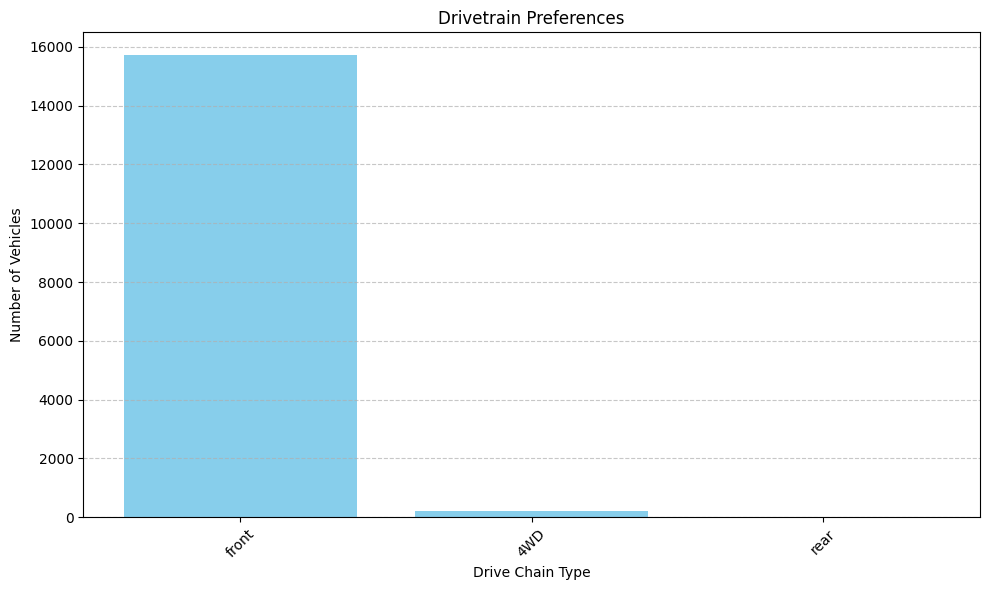

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate drivetrain preferences
drivetrain_counts = (
    df.groupBy("Drive_chain")
    .count()
    .orderBy("count", ascending=False)
    .toPandas()
)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(drivetrain_counts["Drive_chain"], drivetrain_counts["count"], color='skyblue')
plt.title("Drivetrain Preferences")
plt.xlabel("Drive Chain Type")
plt.ylabel("Number of Vehicles")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
#Safety Feature Trends
from pyspark.sql.functions import explode, split

df.withColumn("safety_feature", explode(split(col("Safety_Security"), ", "))) \
  .groupBy("safety_feature").count() \
  .orderBy("count", ascending=False) \
  .show()


+--------------------+-----+
|      safety_feature|count|
+--------------------+-----+
|ABS,Central door ...|  729|
|ABS,Central door ...|  480|
|ABS,Central door ...|  373|
|ABS,Central door ...|  352|
|ABS,Central door ...|  306|
|ABS,Central door ...|  286|
|ABS,Central door ...|  269|
|ABS,Adaptive head...|  152|
|ABS,Central door ...|  123|
|ABS,Central door ...|  114|
|ABS,Driver-side a...|  106|
|ABS,Central door ...|  100|
|ABS,Blind spot mo...|   98|
|Isofix,Tire press...|   92|
|ABS,Central door ...|   85|
|ABS,Central door ...|   83|
|ABS,Central door ...|   82|
|ABS,Central door ...|   80|
|ABS,Central door ...|   79|
|ABS,Central door ...|   79|
+--------------------+-----+
only showing top 20 rows



In [23]:
#Performance Comparison: Compare brands/models
df.groupBy("make_model").agg(avg("price").alias("avg_price")).orderBy("avg_price", ascending=False).show()

+--------------+------------------+
|    make_model|         avg_price|
+--------------+------------------+
|Renault Espace| 30080.21190716448|
|       Audi A2|           28200.0|
| Opel Insignia|21463.451886066206|
|       Audi A3|20996.693251533743|
|       Audi A1|18864.688982402447|
|    Opel Astra|15840.834059405941|
|Renault Duster|13230.176470588236|
|  Renault Clio| 11940.32082653616|
|    Opel Corsa|11061.841606498196|
+--------------+------------------+



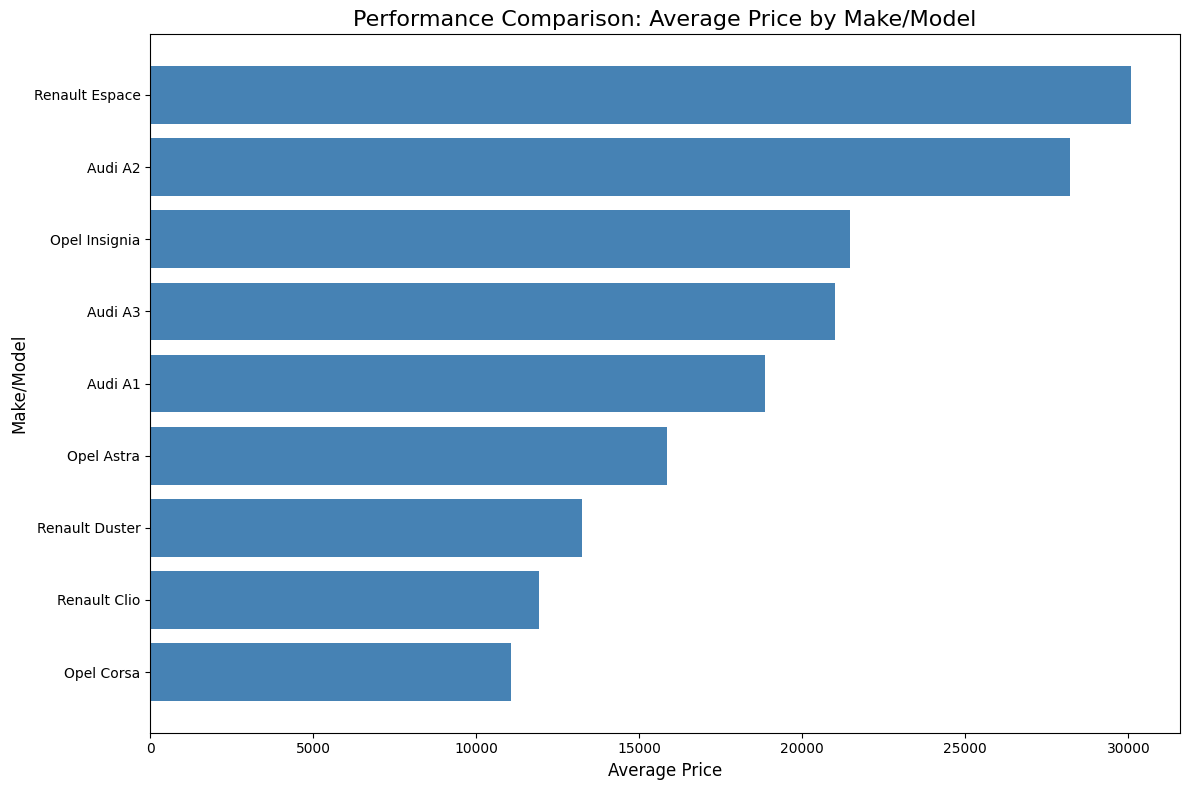

In [25]:
from pyspark.sql.functions import avg
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Aggregate average price by make and model
make_model_avg_price_df = (
    df.groupBy("make_model")
    .agg(avg("price").alias("avg_price"))
    .orderBy("avg_price", ascending=False)
)

# Step 2: Convert to Pandas DataFrame for plotting
make_model_avg_price = make_model_avg_price_df.toPandas()

# Step 3: Generate the bar chart
plt.figure(figsize=(12, 8))
plt.barh(make_model_avg_price["make_model"], make_model_avg_price["avg_price"], color='steelblue')
plt.title("Performance Comparison: Average Price by Make/Model", fontsize=16)
plt.xlabel("Average Price", fontsize=12)
plt.ylabel("Make/Model", fontsize=12)
plt.tight_layout()
plt.gca().invert_yaxis()  # Reverse y-axis for descending order
plt.show()


In [26]:
#Specification Comparison
df.groupBy("make_model").agg(avg("hp_kW").alias("avg_hp_kW"), avg("Displacement_cc").alias("avg_displacement")).show()


+--------------+------------------+------------------+
|    make_model|         avg_hp_kW|  avg_displacement|
+--------------+------------------+------------------+
|    Opel Astra| 92.94970297029703|1429.4471287128713|
|       Audi A1| 76.66143840856924| 1186.641545524101|
|       Audi A2|              85.0|            1598.0|
|       Audi A3|   90.216984178237|1512.1133354859542|
| Opel Insignia|114.53310238645112|  1669.97882986913|
|    Opel Corsa|60.401624548736464|1335.7788808664259|
|Renault Espace|130.18768920282542|1680.2552976791121|
|  Renault Clio| 71.14953779227841|  1261.52691680261|
|Renault Duster| 77.11764705882354|1692.1764705882354|
+--------------+------------------+------------------+



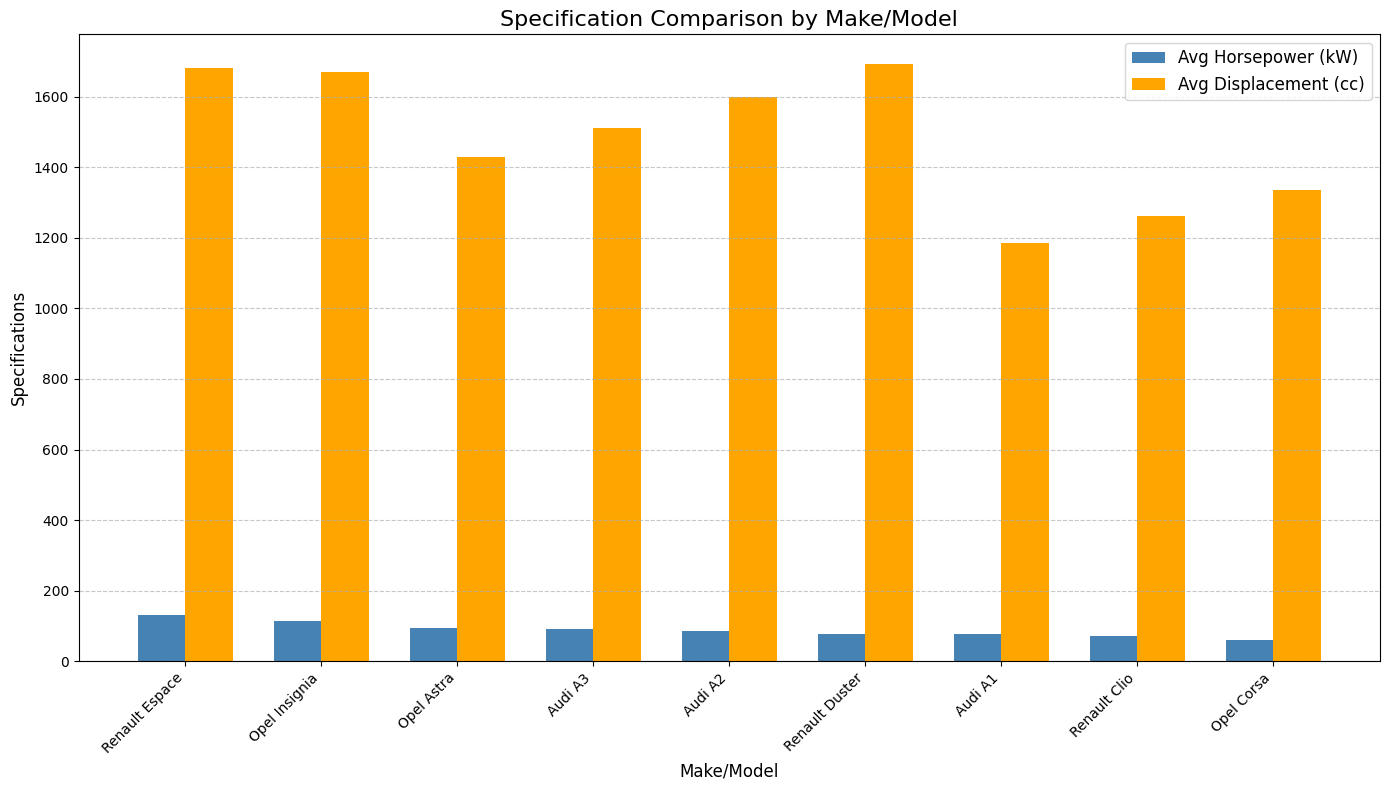

In [27]:
from pyspark.sql.functions import avg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Aggregate average hp_kW and displacement by make and model
spec_comparison_df = (
    df.groupBy("make_model")
    .agg(
        avg("hp_kW").alias("avg_hp_kW"),
        avg("Displacement_cc").alias("avg_displacement")
    )
    .orderBy("avg_hp_kW", ascending=False)  # Optional: Sort by avg_hp_kW for better visualization
)

# Step 2: Convert to Pandas DataFrame for plotting
spec_comparison = spec_comparison_df.toPandas()

# Step 3: Generate a grouped bar chart
x = np.arange(len(spec_comparison["make_model"]))  # Label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 8))
# Bar for avg_hp_kW
plt.bar(x - width/2, spec_comparison["avg_hp_kW"], width, label="Avg Horsepower (kW)", color='steelblue')
# Bar for avg_displacement
plt.bar(x + width/2, spec_comparison["avg_displacement"], width, label="Avg Displacement (cc)", color='orange')

# Customizing the plot
plt.title("Specification Comparison by Make/Model", fontsize=16)
plt.xlabel("Make/Model", fontsize=12)
plt.ylabel("Specifications", fontsize=12)
plt.xticks(x, spec_comparison["make_model"], rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [28]:
#Consumer Preferences


In [29]:
df.groupBy("make_model", "Fuel").count().orderBy("make_model", "count", ascending=False).show()


+--------------+--------+-----+
|    make_model|    Fuel|count|
+--------------+--------+-----+
|Renault Espace|  Diesel|  718|
|Renault Espace| Benzine|  273|
|Renault Duster| Benzine|   34|
|  Renault Clio| Benzine| 1156|
|  Renault Clio|  Diesel|  669|
|  Renault Clio| LPG/CNG|   13|
|  Renault Clio|Electric|    1|
| Opel Insignia|  Diesel| 1715|
| Opel Insignia| Benzine|  883|
|    Opel Corsa| Benzine| 2051|
|    Opel Corsa|  Diesel|  152|
|    Opel Corsa| LPG/CNG|   13|
|    Opel Astra| Benzine| 1385|
|    Opel Astra|  Diesel| 1138|
|    Opel Astra| LPG/CNG|    2|
|       Audi A3|  Diesel| 2119|
|       Audi A3| Benzine|  938|
|       Audi A3| LPG/CNG|   36|
|       Audi A3|Electric|    4|
|       Audi A2|  Diesel|    1|
+--------------+--------+-----+
only showing top 20 rows



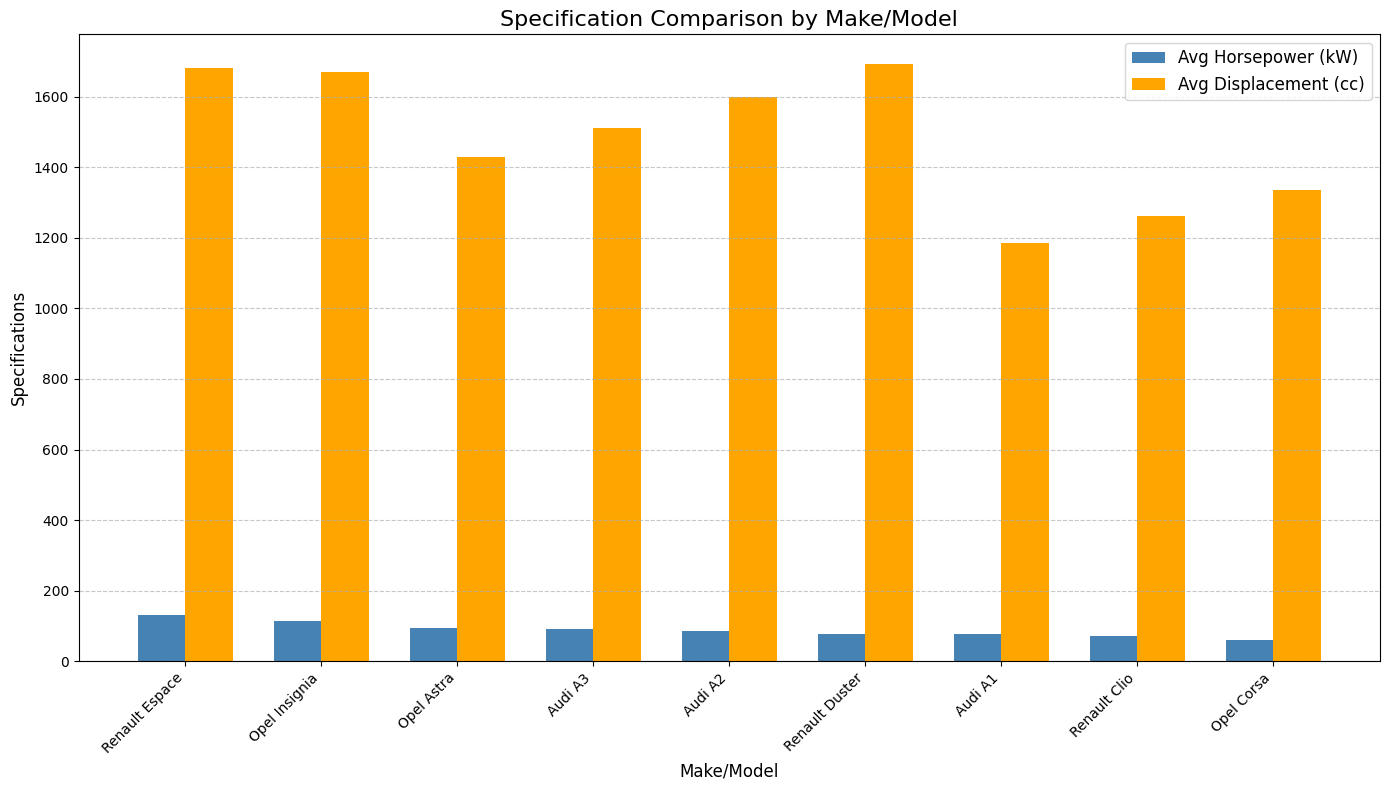

In [30]:
from pyspark.sql.functions import avg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Aggregate average hp_kW and displacement by make and model
spec_comparison_df = (
    df.groupBy("make_model")
    .agg(
        avg("hp_kW").alias("avg_hp_kW"),
        avg("Displacement_cc").alias("avg_displacement")
    )
    .orderBy("avg_hp_kW", ascending=False)  # Optional: Sort by avg_hp_kW for better visualization
)

# Step 2: Convert to Pandas DataFrame for plotting
spec_comparison = spec_comparison_df.toPandas()

# Step 3: Generate a grouped bar chart
x = np.arange(len(spec_comparison["make_model"]))  # Label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 8))
# Bar for avg_hp_kW
plt.bar(x - width/2, spec_comparison["avg_hp_kW"], width, label="Avg Horsepower (kW)", color='steelblue')
# Bar for avg_displacement
plt.bar(x + width/2, spec_comparison["avg_displacement"], width, label="Avg Displacement (cc)", color='orange')

# Customizing the plot
plt.title("Specification Comparison by Make/Model", fontsize=16)
plt.xlabel("Make/Model", fontsize=12)
plt.ylabel("Specifications", fontsize=12)
plt.xticks(x, spec_comparison["make_model"], rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


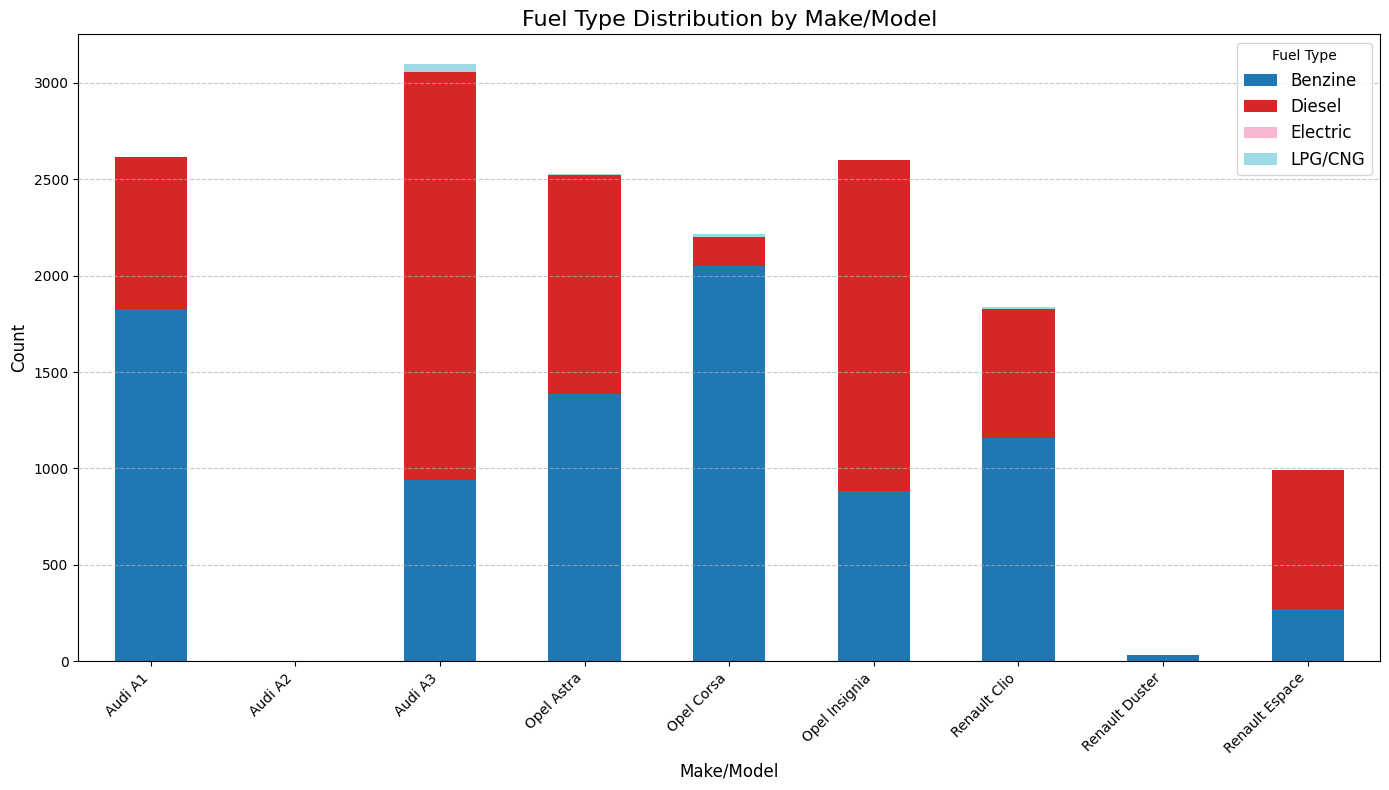

In [31]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Aggregate count by make_model and Fuel
fuel_distribution_df = (
    df.groupBy("make_model", "Fuel")
    .count()
    .orderBy("make_model", "count", ascending=False)
)

# Step 2: Convert to Pandas for plotting
fuel_distribution = fuel_distribution_df.toPandas()

# Step 3: Pivot the data for plotting
fuel_pivot = fuel_distribution.pivot(index="make_model", columns="Fuel", values="count").fillna(0)

# Step 4: Generate a stacked bar chart
fuel_pivot.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="tab20")

# Customizing the plot
plt.title("Fuel Type Distribution by Make/Model", fontsize=16)
plt.xlabel("Make/Model", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Fuel Type", fontsize=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [32]:
#Identify compact cars with low fuel consumption and automatic gearing
df.filter((col("body_type").isin("Hatchback", "Compact")) & (col("Gearing_Type") == "Automatic")) \
  .groupBy("Fuel", "body_type") \
  .agg(avg("cons_comb").alias("avg_consumption"), avg("price").alias("avg_price")) \
  .orderBy("avg_consumption") \
  .show()


+-------+---------+-----------------+------------------+
|   Fuel|body_type|  avg_consumption|         avg_price|
+-------+---------+-----------------+------------------+
| Diesel|  Compact|4.015508021390374|17832.486631016043|
|Benzine|  Compact|5.433050161812305|17704.078478964402|
+-------+---------+-----------------+------------------+



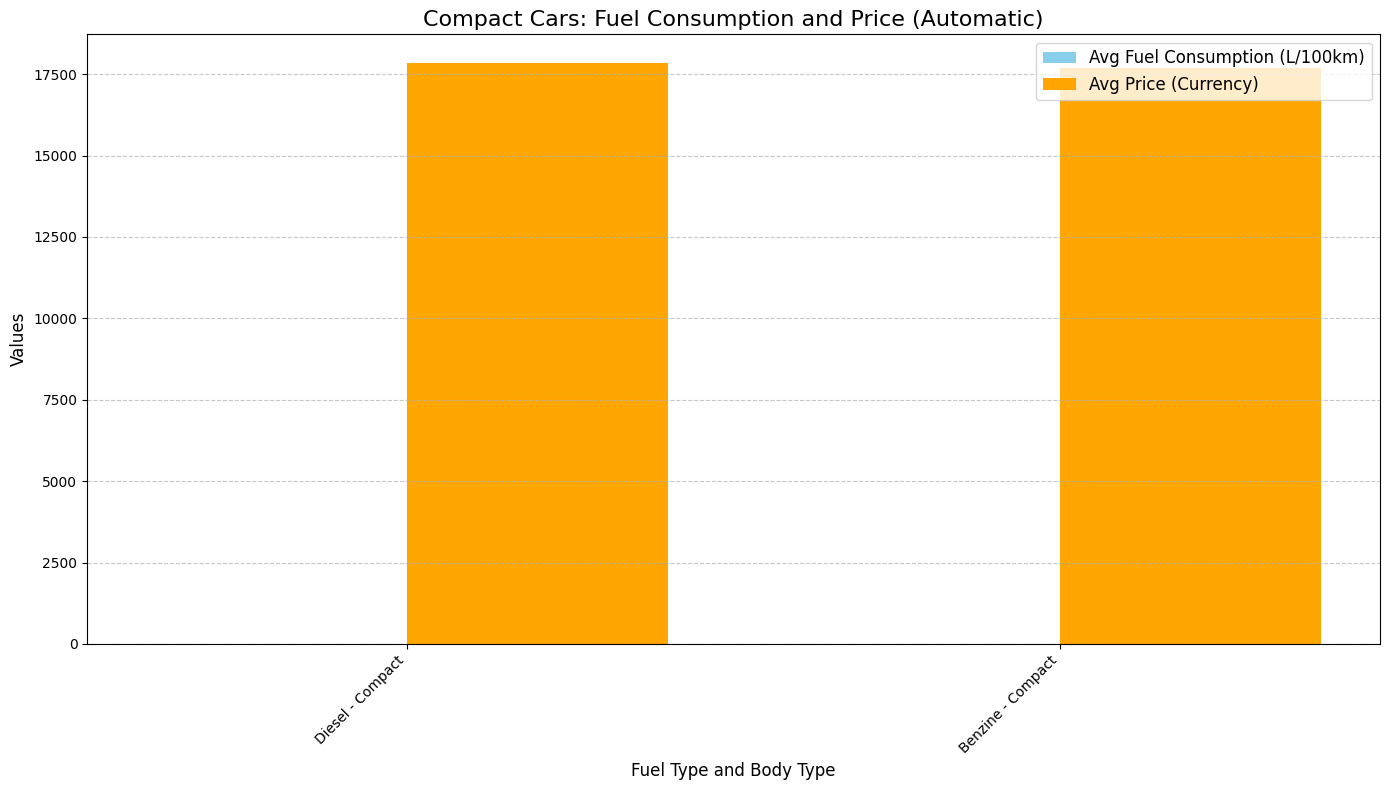

In [33]:
from pyspark.sql.functions import col, avg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter for compact cars with low fuel consumption and automatic gearing
compact_cars_df = (
    df.filter((col("body_type").isin("Hatchback", "Compact")) & (col("Gearing_Type") == "Automatic"))
    .groupBy("Fuel", "body_type")
    .agg(
        avg("cons_comb").alias("avg_consumption"),
        avg("price").alias("avg_price")
    )
    .orderBy("avg_consumption")
)

# Step 2: Convert to Pandas for plotting
compact_cars = compact_cars_df.toPandas()

# Step 3: Generate a grouped bar chart for average fuel consumption and price
x = np.arange(len(compact_cars))  # Label locations
width = 0.4  # Width of the bars

plt.figure(figsize=(14, 8))

# Bar for average fuel consumption
plt.bar(x - width/2, compact_cars["avg_consumption"], width, label="Avg Fuel Consumption (L/100km)", color="skyblue")

# Bar for average price
plt.bar(x + width/2, compact_cars["avg_price"], width, label="Avg Price (Currency)", color="orange")

# Customizing the plot
plt.title("Compact Cars: Fuel Consumption and Price (Automatic)", fontsize=16)
plt.xlabel("Fuel Type and Body Type", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(x, compact_cars["Fuel"] + " - " + compact_cars["body_type"], rotation=45, ha="right", fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [34]:
#Identify high-performance cars with the best power-to-weight ratio
df.withColumn("power_to_weight", col("hp_kW") / col("Weight_kg")) \
  .filter(col("power_to_weight") > 0.1) \
  .select("make_model", "body_type", "hp_kW", "Weight_kg", "power_to_weight", "price") \
  .orderBy("power_to_weight", ascending=False) \
  .show()

+----------+-------------+-----+---------+-------------------+-----+
|make_model|    body_type|hp_kW|Weight_kg|    power_to_weight|price|
+----------+-------------+-----+---------+-------------------+-----+
|   Audi A3|      Compact|294.0|   1485.0|0.19797979797979798|67600|
|   Audi A3|       Sedans|294.0|   1490.0|0.19731543624161074|74600|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|52000|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|64900|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|62900|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|56900|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|58500|
|   Audi A3|Station wagon|294.0|   1585.0|0.18548895899053627|63900|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|57400|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|55000|
|   Audi A3|       Sedans|294.0|   1585.0|0.18548895899053627|51900|
|   Audi A3|       Sedans|294.0|  

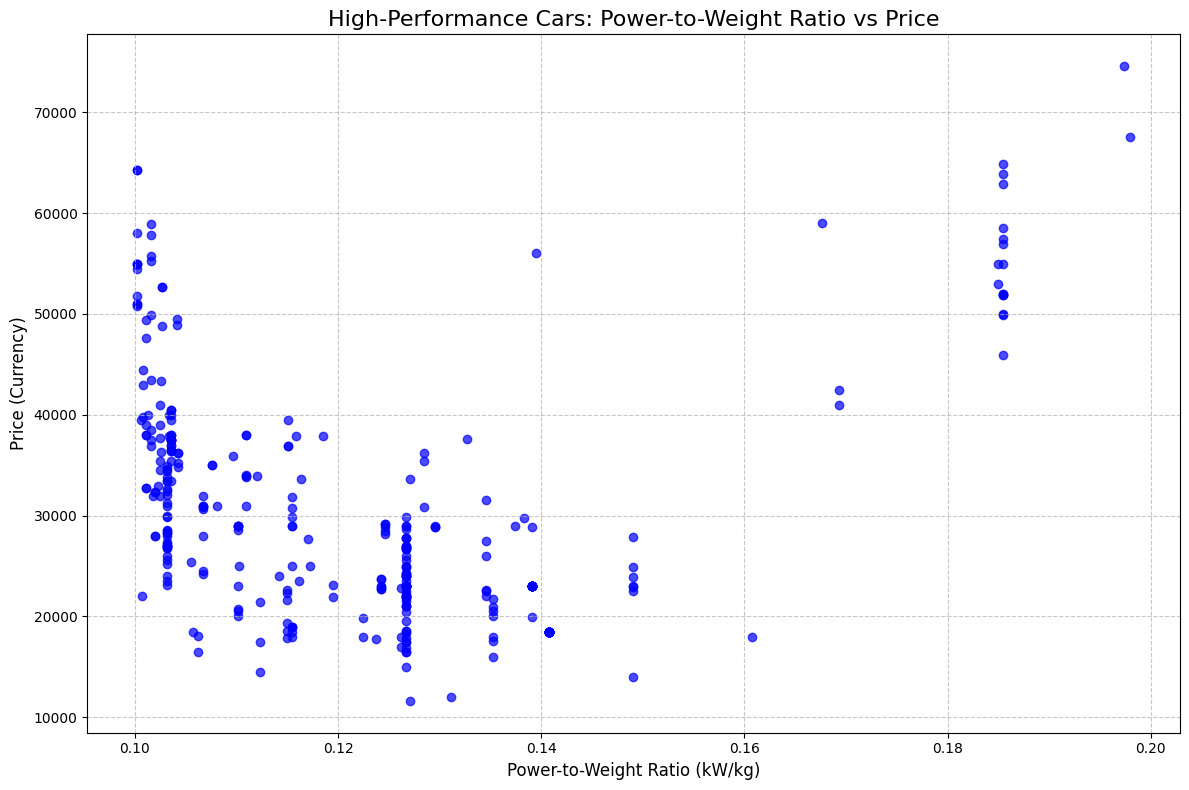

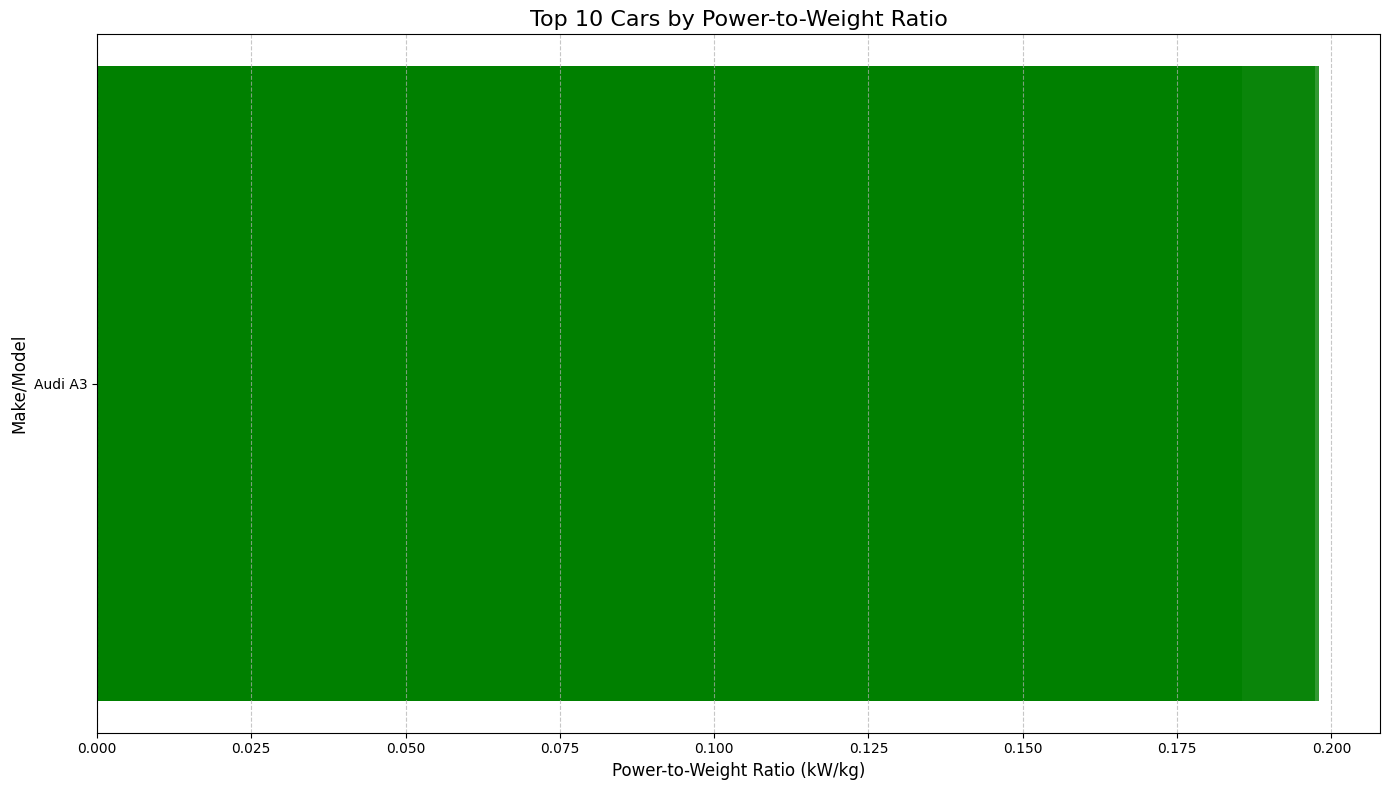

In [35]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate power-to-weight ratio and filter high-performance cars
high_perf_cars_df = (
    df.withColumn("power_to_weight", col("hp_kW") / col("Weight_kg"))
    .filter(col("power_to_weight") > 0.1)
    .select("make_model", "body_type", "hp_kW", "Weight_kg", "power_to_weight", "price")
    .orderBy("power_to_weight", ascending=False)
)

# Step 2: Convert to Pandas for visualization
high_perf_cars = high_perf_cars_df.toPandas()

# Step 3: Scatter plot for power-to-weight ratio vs price
plt.figure(figsize=(12, 8))
plt.scatter(high_perf_cars["power_to_weight"], high_perf_cars["price"], c="blue", alpha=0.7)
plt.title("High-Performance Cars: Power-to-Weight Ratio vs Price", fontsize=16)
plt.xlabel("Power-to-Weight Ratio (kW/kg)", fontsize=12)
plt.ylabel("Price (Currency)", fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 4: Bar chart for top 10 cars by power-to-weight ratio
top_10_cars = high_perf_cars.head(10)
plt.figure(figsize=(14, 8))
plt.barh(top_10_cars["make_model"], top_10_cars["power_to_weight"], color="green", alpha=0.8)
plt.title("Top 10 Cars by Power-to-Weight Ratio", fontsize=16)
plt.xlabel("Power-to-Weight Ratio (kW/kg)", fontsize=12)
plt.ylabel("Make/Model", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
